<a href="https://colab.research.google.com/github/plaban1981/Dphi_hackathon/blob/main/Cassava_plant_disease_classification_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"plabannayak","key":"a921523e2a322480945429f26096563d"}'}

In [1]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 7.0MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=31d00f36a6cbd7111f019ea1d9921f9f52dcfdd6c8c41ead5fbac0c194224ffa
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets list

ref                                                           title                                                size  lastUpdated          downloadCount  
------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
utkarshxy/who-worldhealth-statistics-2020-complete            World Health Statistics 2020|Complete|Geo-Analysis    1MB  2021-01-08 17:42:25           1676  
gpreda/pfizer-vaccine-tweets                                  Pfizer Vaccine Tweets                               484KB  2021-01-09 22:29:30           1128  
arashnic/covid19-case-surveillance-public-use-dataset         Covid-19 Case Surveillance Public Use Dataset        46MB  2020-12-21 02:24:21            847  
ashkhagan/women-representation-in-city-property-sanfrancisco  Women Representation in City Property SanFrancisco    3KB  2020-12-13 05:18:14            250  
google/android-smartphones-high-accuracy-datasets   

In [5]:
!kaggle competitions download -c cassava-leaf-disease-classification

100% 5.76G/5.76G [02:03<00:00, 38.1MB/s]
100% 5.76G/5.76G [02:03<00:00, 50.0MB/s]


In [6]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [7]:
!unzip "/content/cassava-leaf-disease-classification.zip" -d "/content/drive/MyDrive/kaggle"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/kaggle/train_images/3954399974.jpg  
  inflating: /content/drive/MyDrive/kaggle/train_images/3954487465.jpg  
  inflating: /content/drive/MyDrive/kaggle/train_images/3954910918.jpg  
  inflating: /content/drive/MyDrive/kaggle/train_images/3955391972.jpg  
  inflating: /content/drive/MyDrive/kaggle/train_images/3955442838.jpg  
  inflating: /content/drive/MyDrive/kaggle/train_images/3955739563.jpg  
  inflating: /content/drive/MyDrive/kaggle/train_images/3955931830.jpg  
  inflating: /content/drive/MyDrive/kaggle/train_images/3955972139.jpg  
  inflating: /content/drive/MyDrive/kaggle/train_images/3956075690.jpg  
  inflating: /content/drive/MyDrive/kaggle/train_images/3956077728.jpg  
  inflating: /content/drive/MyDrive/kaggle/train_images/3956155774.jpg  
  inflating: /content/drive/MyDrive/kaggle/train_images/3956271103.jpg  
  inflating: /content/drive/MyDrive/kaggle/train_images/3956372146.jpg  


In [8]:
import pandas as pd
import numpy as np
from fastai import *
from fastai.vision import *
from fastai.callbacks.tracker import *
from sklearn.model_selection import StratifiedKFold
from pathlib import Path
import shutil
from sklearn.metrics import f1_score, confusion_matrix

np.random.seed(1786)
ROOT = "/content/drive/MyDrive/kaggle"

In [9]:
import pandas as pd
train_df = pd.read_csv("/content/drive/MyDrive/kaggle/train.csv")

In [10]:
train_df.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

In [14]:
import json
# Opening JSON file 
f = open('/content/drive/MyDrive/kaggle/label_num_to_disease_map.json',) 
  
# returns JSON object as  
# a dictionary 
data = json.load(f) 
  
print(data)
print(type(data))
  
# Closing file 
f.close() 

{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}
<class 'dict'>


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


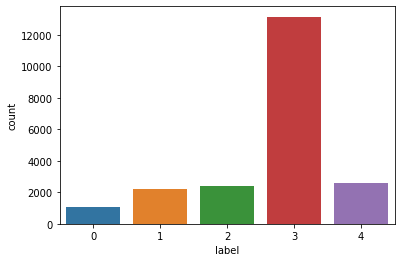

In [15]:
import seaborn as sns
sns.countplot(train_df['label'])

In [16]:
hack_path = "/content/drive/MyDrive/kaggle"
train_path = "/content/drive/MyDrive/kaggle/train_images"
test_path = "/content/drive/MyDrive/kaggle/test_images"
def get_data(bs, size):
    data = ImageDataBunch.from_df(df=train_df, path=train_path,
                                  bs=bs, size=size, valid_pct=0.1, 
                                  resize_method=ResizeMethod.SQUISH, 
                                  ds_tfms=get_transforms(max_lighting=0.4, max_zoom=1.2, 
                                                         max_warp=0.2, max_rotate=20, 
                                                         xtra_tfms=[flip_lr()]))
    test_data = ImageList.from_folder(path=test_path)
    data.add_test(test_data)
    data.normalize(imagenet_stats)
    return data

In [18]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
data = get_data(bs=32, size=224)

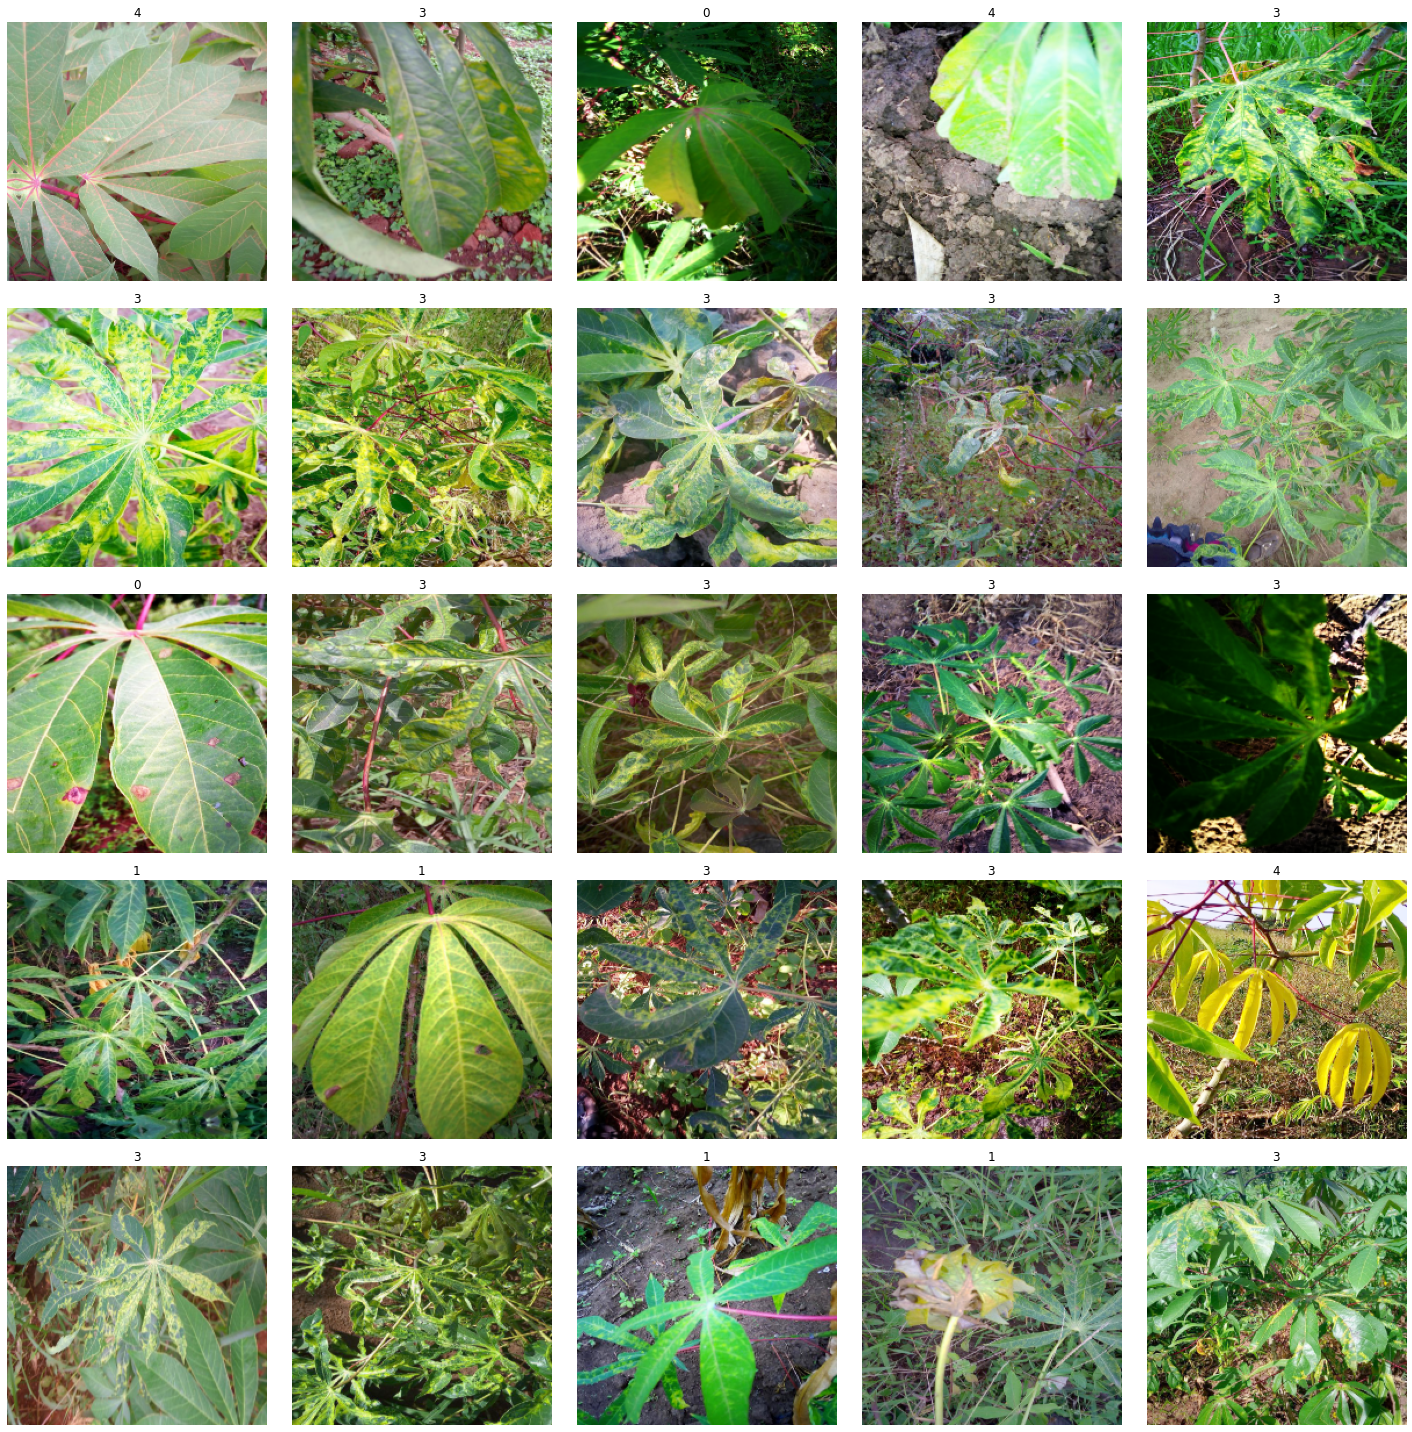

In [20]:
data.show_batch()

In [21]:
class SaveBestModel(Recorder):
    def __init__(self, learn,name='best_model'):
        super().__init__(learn)
        self.name = name
        self.best_loss = None
        self.best_acc = None
        self.save_method = self.save_when_acc
        
    def save_when_acc(self, metrics):        
        loss, acc = metrics[0], metrics[1]
        if (self.best_acc is None) or (acc > self.best_acc) or (loss < self.best_loss):
            self.best_acc = acc
            self.best_loss = loss
            self.learn.save(f'{self.name}')
            print("Save the best acc {:.5f}".format(self.best_acc))
        elif acc == self.best_acc and  loss < self.best_loss:
            self.best_loss = loss
            self.learn.save(f'{self.name}')
            print("Acc is eq,Save the lower loss {:.5f}".format(self.best_loss))
            
    def on_epoch_end(self,last_metrics=MetricsList,**kwargs:Any):
        self.save_method(last_metrics)

In [23]:
train_df.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

In [27]:
ROOT = "/content/drive/MyDrive/kaggle"

In [ ]:
if __name__=="__main__":
    #train_df, test_df = read_data(ROOT)
    print(train_df.shape)
    
    cvlist = list(StratifiedKFold(16, random_state=12345786).split(train_df, train_df.label))
    
    tfms1 = get_transforms(max_zoom=1.5)
    test_preds_all = []
    val_preds_all = []
    for i in range(3):
        print("Starting fold {}".format(i))
        tr_idx, val_idx = cvlist[i]
        print(tr_idx.shape, val_idx.shape)
        src = (ImageList.from_df(train_df, path=ROOT, folder="train_images").split_by_idxs(tr_idx, val_idx)
                                                            .label_from_df())
        data = ImageDataBunch.create_from_ll(src, ds_tfms=tfms1, size=224, bs=32, resize_method=ResizeMethod.SQUISH).normalize(imagenet_stats)
        data.add_test(ImageList.from_folder(path=test_path))
        learn = cnn_learner(data, models.resnet152, metrics=[FBeta(beta=1, average='macro'), accuracy], ps=0.2)
        # learn.model[0].load_state_dict(torch.load("../input/save-body-weights-marvel/bestmodel_body.path"))
        cb = SaveBestModel(learn, name="bestmodel_{}".format(i))
        # learn.fit(1, callbacks=cb)
        learn.lr_find()
        learn.recorder.plot(suggestion=True)
        min_grad_lr = learn.recorder.min_grad_lr
        learn.fit_one_cycle(5,min_grad_lr)
        learn.unfreeze()
        learn.lr_find()
        learn.recorder.plot(suggestion=True)
        min_grad_lr = learn.recorder.min_grad_lr
        learn.fit_one_cycle(5, min_grad_lr , callbacks=[cb])
        #learn.fit_one_cycle(6, max_lr=1e-4, callbacks=[cb,ReduceLROnPlateauCallback(learn, monitor='valid_loss', mode='auto', patience=1, factor=0.2, min_delta=1, min_lr=0.001)])
        #learn.fit_one_cycle(5, max_lr=1e-4/8, callbacks=[cb,ReduceLROnPlateauCallback(learn, monitor='valid_loss', mode='auto', patience=1, factor=0.2, min_delta=1, min_lr=0.001)])
        learn.fit_one_cycle(4, min_grad_lr, callbacks=[cb])
        #learn.fit_one_cycle(3, max_lr=5e-6, callbacks=[cb])
        learn.fit_one_cycle(3, min_grad_lr, callbacks=[cb])
        #learn.fit_one_cycle(2, max_lr=1e-6, callbacks=[cb])
        learn.load("bestmodel_{}".format(i))
        val_preds, y = learn.TTA(ds_type=DatasetType.Valid)
        val_preds = np.exp(val_preds.numpy())
        print("F1 score for this fold ",f1_score(y.numpy(), np.argmax(val_preds,axis=1), average='weighted'))
        test_preds = np.exp(learn.TTA(ds_type=DatasetType.Test)[0].numpy())
        test_preds_all.append(test_preds)
        val_preds_all.append(val_preds)
        fname = "bestmodel_{}.pth".format(i)
        src = str(Path(ROOT) / "models" / fname)
        shutil.copy(src, fname)
    test_preds_all = np.mean(test_preds_all, axis=0)
    val_preds_all = np.concatenate(val_preds_all, axis=0)

(21397, 2)
Starting fold 0
(20059,) (1338,)


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-02
Min loss divided by 10: 2.75E-03


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-05
Min loss divided by 10: 6.31E-08


Save the best acc 0.68086
Save the best acc 0.68990
Save the best acc 0.68976
Save the best acc 0.69293
Save the best acc 0.67933


Save the best acc 0.68659
Save the best acc 0.69051
Save the best acc 0.69529


Save the best acc 0.69785
Save the best acc 0.69838


F1 score for this fold  0.8516077743669863


Starting fold 1
(20059,) (1338,)
